# Graph Linear Automaton

### Problem description

We define a graph of "microorganisms" as $G = (V, E)$, where $V$ is the set of vertices $v_i \in V$, and $E$ is a set of unordered pairs $\{u, v\}$, $u,v \in V$. Each vertex has a state value $x_i \in (0, 1)$. We can discretize the values in time domain by introducing $t \in 1, ..., T$ and update the value in each cell with using logistic formula:

$$
    x_i^{t+1} = m A_i^t (1 - A_i^t),
$$

where:
- $m$ is some growth parameter from the interval $[2, 4]$.
- $A_i^t$ is the average of neighbor values of $i$-th node and time $t$.

### Graph generation

For big graphs (more than 10k vertices) its better to store the graph in the form of adjacency list. First we can focus on generating the graphs. Lets generate few types of graphs:
- 2D grid (wrapping edges)
- Ring with additional k-neighbors connections
- Hypercube
- Random Graph with given degree

In [1]:
import numpy as np

from graph_generator import RegularGraphGenerator
from layout_generator import LayoutGenerator, VectorizedForceLayout, plot_graph

graphs = {
    "2d-grid":    np.array(RegularGraphGenerator.generate_toroidal_grid(33, 33)),
    "ring5":      np.array(RegularGraphGenerator.generate_ring_regular(1000, 4)),
    "hypercube":  np.array(RegularGraphGenerator.generate_hypercube(10)),
    "random5":    np.array(RegularGraphGenerator.generate_random_regular_connected(1000, 5)),
    "random10":   np.array(RegularGraphGenerator.generate_random_regular_connected(1000, 10)),
    "random15":   np.array(RegularGraphGenerator.generate_random_regular_connected(1000, 15)),
}

coords = {
    "2d-grid":    LayoutGenerator.layout_grid_2d(33, 33),
    "ring5":      LayoutGenerator.layout_circular(1000),
    "hypercube":  VectorizedForceLayout(graphs["hypercube"], 10, 10).run(),
    "random5":    VectorizedForceLayout(graphs["random5"],   10, 10).run(),
    "random10":   VectorizedForceLayout(graphs["random10"],  10, 10).run(),
    "random15":   VectorizedForceLayout(graphs["random15"],  10, 10).run(),
}

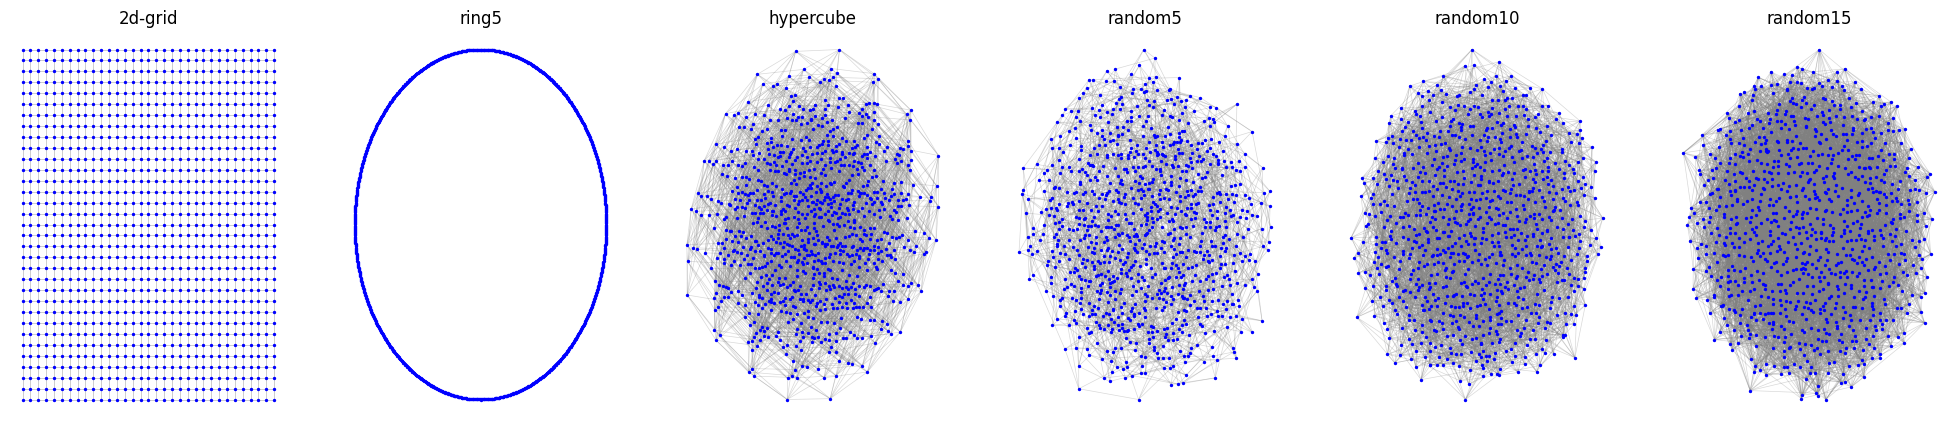

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(graphs), figsize=(30, 5))
for i, (name, graph) in enumerate(graphs.items()):
    plot_graph(ax[i], graph, coords=coords[name], title=name)

### Simulation

First we will test initializing the values from $\mathcal{U}(0, 1)$.

In [11]:
from simulation import simulate

for i, (name, graph) in enumerate(graphs.items()):
    simulate(
        adj=graph,
        coords=coords[name],
        steps=2000,
        m=4,
        plot_every=10,
        values_init="uniform",
        output_folder=f"simulations/3/{name}",
    )

Output folder 'simulations/3/2d-grid' created/cleared.
Simulation started for N=1089 nodes, T=2000 steps, m=4
Simulation complete. Frames saved to /simulations/3/2d-grid
Output folder 'simulations/3/ring5' created/cleared.
Simulation started for N=1000 nodes, T=2000 steps, m=4
Simulation complete. Frames saved to /simulations/3/ring5
Output folder 'simulations/3/hypercube' created/cleared.
Simulation started for N=1024 nodes, T=2000 steps, m=4
Simulation complete. Frames saved to /simulations/3/hypercube
Output folder 'simulations/3/random5' created/cleared.
Simulation started for N=1000 nodes, T=2000 steps, m=4
Simulation complete. Frames saved to /simulations/3/random5
Output folder 'simulations/3/random10' created/cleared.
Simulation started for N=1000 nodes, T=2000 steps, m=4
Simulation complete. Frames saved to /simulations/3/random10
Output folder 'simulations/3/random15' created/cleared.
Simulation started for N=1000 nodes, T=2000 steps, m=4
Simulation complete. Frames saved to 

In [10]:
from gifs import make_gif

for name in graphs.keys():
    make_gif(f"simulations/3/{name}", "figures/gifs/3", f"{name}.gif")